In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns

from sklearn import metrics

In [2]:
psd_mat_path = r'Z:\Data\InternalStateClustering\out\psd_mat.csv'
psd_freqs_path = r'Z:\Data\InternalStateClustering\out\psd_freqs.csv'
categories_path = r'Z:\Data\InternalStateClustering\out\categories.csv'

In [3]:
def chooseDataset(X, Y, Y_list, balancing=False, max_tol_imbalance_ratio=1):
    in_idcs = np.where([(cat in Y_list) for cat in Y])[0]
    if balancing:
        samp_idcs_list = [np.where(Y==Y_target)[0] for Y_target in np.unique(Y_list)]
        samp_size_list = [len(idcs) for idcs in samp_idcs_list]
        max_tol_size = np.floor(min(samp_size_list) * max_tol_imbalance_ratio).astype(int)
        samp_idcs_list_balanced = [np.random.choice(idcs, min(len(idcs), max_tol_size), replace=False) for idcs in samp_idcs_list]
        balanced_idcs = np.concatenate(samp_idcs_list_balanced, axis=0)
        print('%d in %d samples dicarded due to imbalance. ' % (len(in_idcs) - len(balanced_idcs), len(in_idcs)))
        X_chosen = X[balanced_idcs, :]
        Y_chosen = Y[balanced_idcs]
    else:
        X_chosen = X[in_idcs, :]
        Y_chosen = Y[in_idcs]
    return X_chosen, Y_chosen

def splitDataset(X, Y, test_ratio):
    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []
    for Y_class in np.unique(Y):
        X_sub, Y_sub = chooseDataset(X, Y, Y_class)
        n = X_sub.shape[0]
        n_train = np.floor(n * (1-test_ratio)).astype(int)
        assert(n_train > 0)
        idx_train = np.random.choice(np.arange(n), n_train, replace=False)
        idx_test = np.setdiff1d(np.arange(n), idx_train)
        X_train_list.append(X_sub[idx_train,:])
        X_test_list.append(X_sub[idx_test,:])
        Y_train_list.append(Y_sub[idx_train])
        Y_test_list.append(Y_sub[idx_test])
    X_train = np.concatenate(X_train_list, axis=0)
    X_test = np.concatenate(X_test_list, axis=0)
    Y_train = np.concatenate(Y_train_list, axis=0)
    Y_test = np.concatenate(Y_test_list, axis=0)
    return X_train, X_test, Y_train, Y_test

def normalize(X):
    return (X - np.mean(X)) / np.std(X)

def normalize_list(X_list):
    return (normalize(X) for X in X_list)

from scipy.stats import ttest_ind
def doTtest(X, Y):
    assert(len(np.unique(Y))==2)
    assert(len(X.shape)==1)
    class_names = np.unique(Y)
    result = ttest_ind(X[Y==class_names[0]], X[Y==class_names[1]], equal_var=False)
    return result

In [5]:
psd_mat = np.loadtxt(psd_mat_path, delimiter=',')
psd_freqs = np.loadtxt(psd_freqs_path, delimiter=',')
categories = np.loadtxt(categories_path, dtype='str', delimiter=',')
psd_mat.shape, psd_freqs.shape, categories.shape

((2784, 40), (40,), (2784,))

In [6]:
# psd_mat = psd_mat[:, 3:]

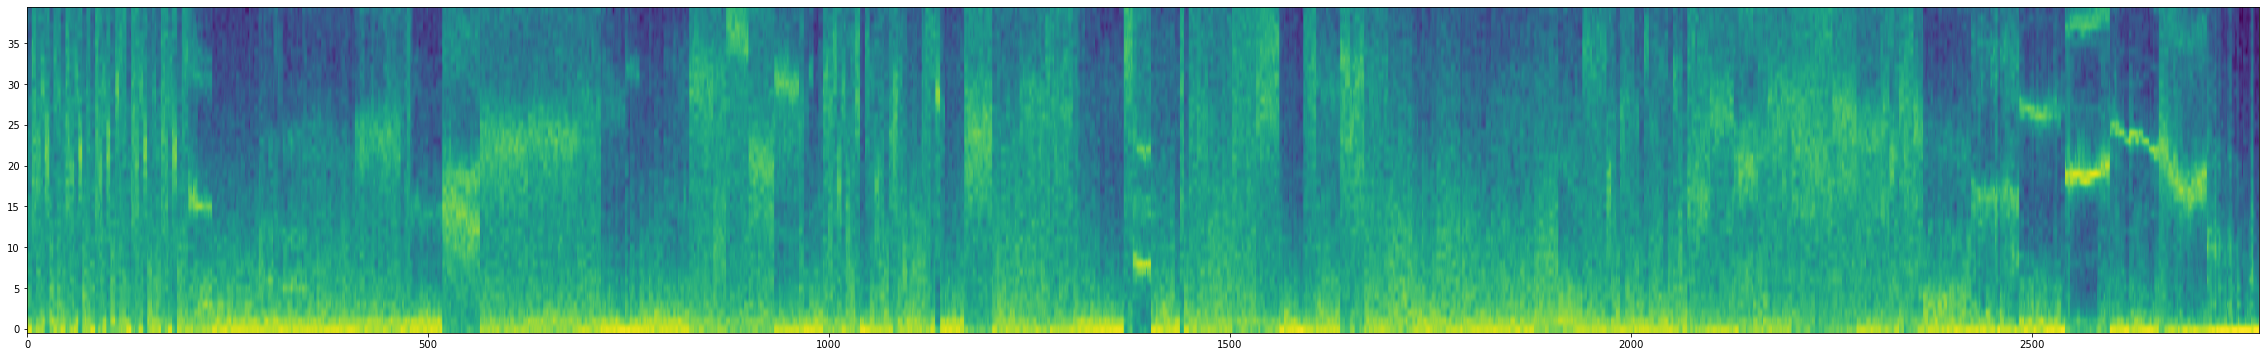

In [16]:
plt.figure(figsize=[40, 6])
plt.imshow(np.log(psd_mat).T, aspect='auto', origin='lower')

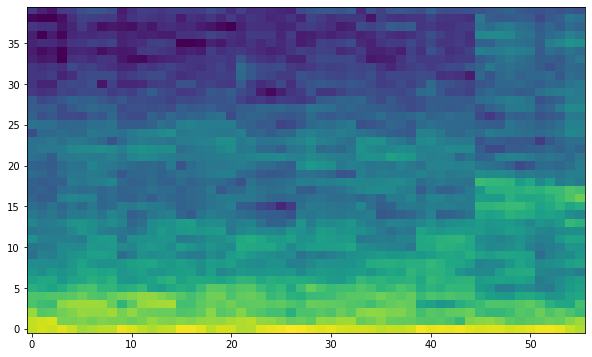

In [7]:
plt.figure(figsize=[10, 6])
plt.imshow(np.log(psd_mat[2312:2368]).T, aspect='auto', origin='lower')

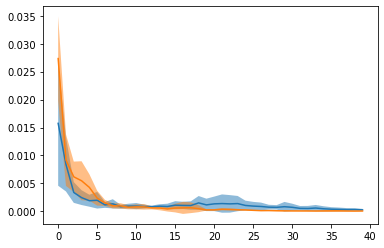

In [8]:
psd_mat1_mean = np.mean(psd_mat[:54], axis=0)
psd_mat1_stdd = np.std(psd_mat[:54], axis=0)
plt.plot(psd_mat1_mean)
plt.fill_between(np.arange(40), psd_mat1_mean - psd_mat1_stdd, psd_mat1_mean + psd_mat1_stdd, alpha=0.5)

psd_mat2_mean = np.mean(psd_mat[2312:2368], axis=0)
psd_mat2_stdd = np.std(psd_mat[2312:2368], axis=0)
plt.plot(psd_mat2_mean)
plt.fill_between(np.arange(40), psd_mat2_mean - psd_mat2_stdd, psd_mat2_mean + psd_mat2_stdd, alpha=0.5)

# plt.yscale('log')


In [8]:
# datasets
datasets = {'age': ['Normal', '28Day', '14Day'], 
            'feeding': ['Normal', 'Thirste', 'Starved'], 
            'mating': ['Normal', 'Failed', 'Mated'], 
            'mating_2': ['Normal', 'Mated'], 
            'mating_3': ['Failed', 'Mated']}

# LDA

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [10]:
datasets['age']

['Normal', '28Day', '14Day']

In [88]:
def make_ellipses(transmeans,transcovariance, ax):
   
    v, w = np.linalg.eigh(transcovariance)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(
        transmeans, v[0], v[1], 180 + angle)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.8)
    ax.add_artist(ell)
    ax.set_aspect("equal", "datalim")
    print(transmeans, v)


681 in 1284 samples dicarded due to imbalance. 
n_epochs: 100
f1_score_train: 0.727 (+- 0.015)
f1_score_test: 0.661 (+- 0.037)
[1.1231347  0.16326199] [0.02927699 0.03802455]
[1.12475794 0.15681586] [0.03041234 0.03869741]
[1.12471737 0.16059216] [0.02885878 0.0394449 ]
[1.12422821 0.16423535] [0.02923517 0.03744748]
[1.12120184 0.16394139] [0.02951533 0.03707147]
[1.12120184 0.16394139] [0.02951533 0.03707147]


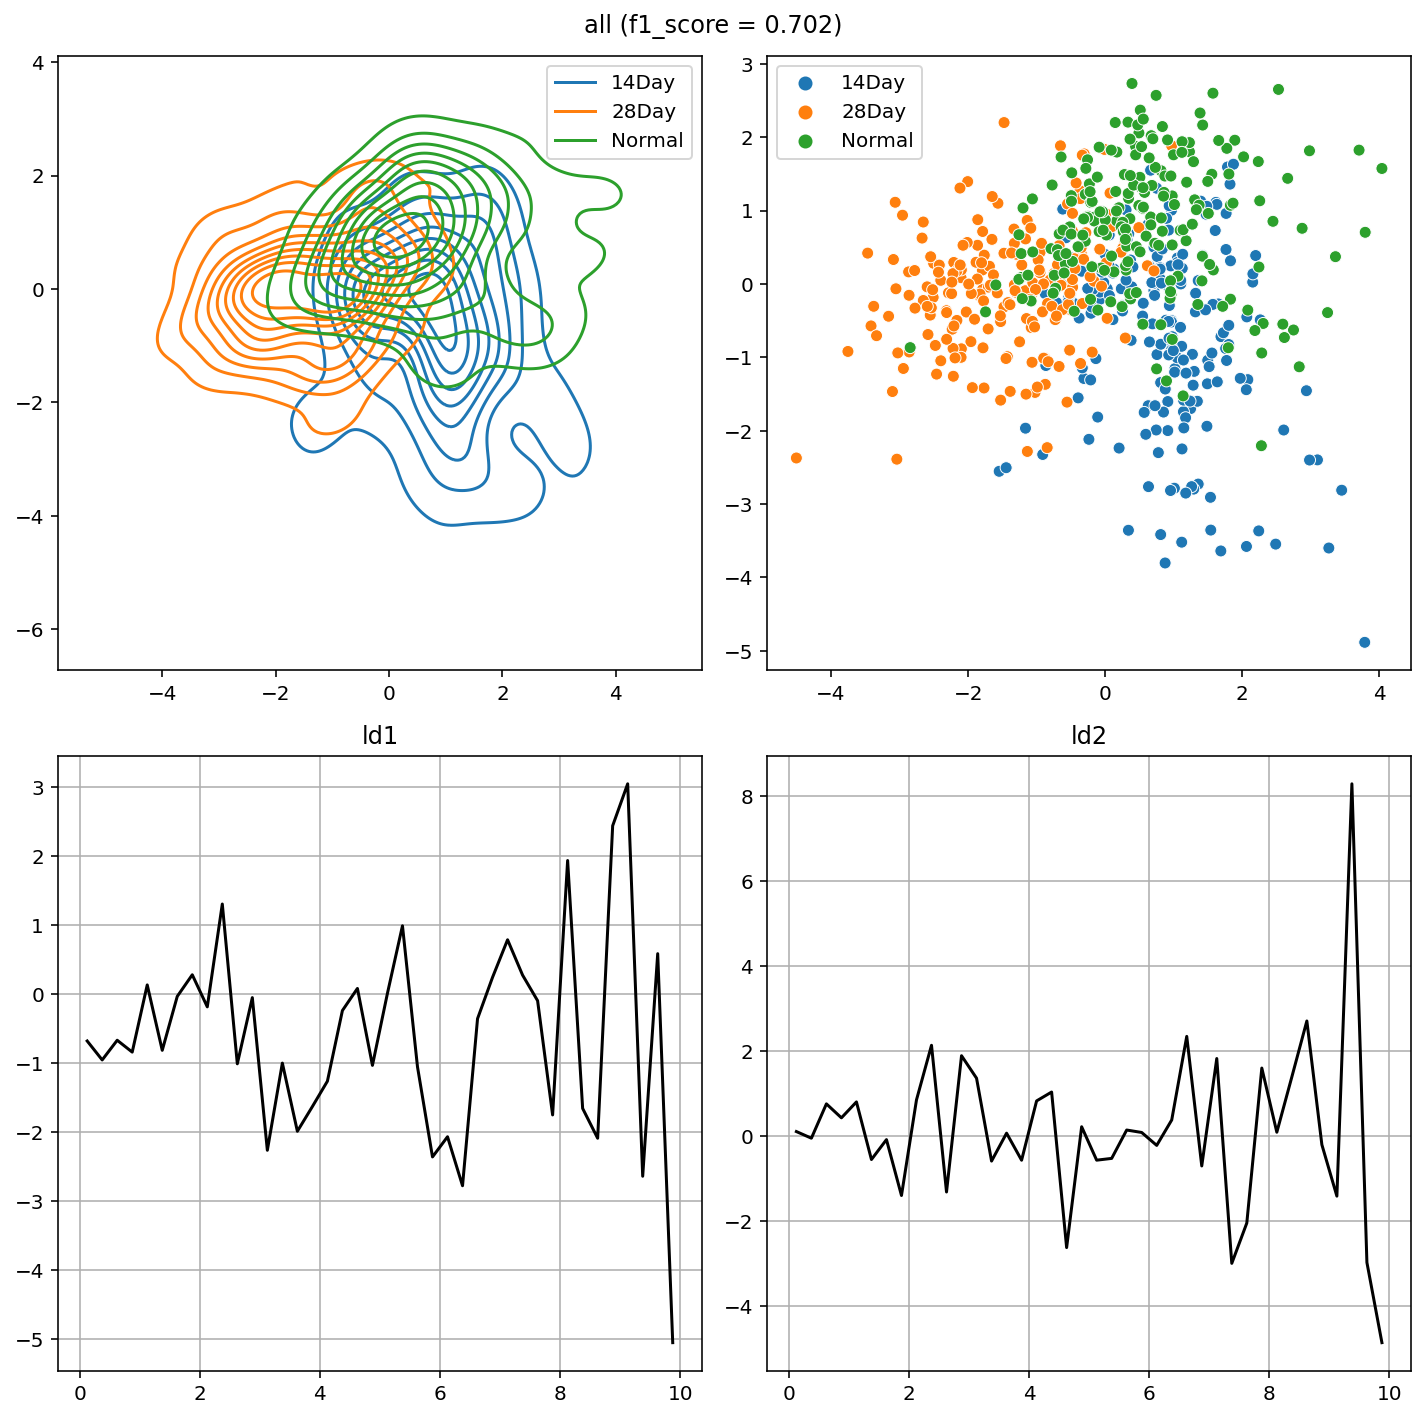

In [92]:
X, Y = chooseDataset(psd_mat, categories, datasets['age'], balancing=True)
X = normalize(X)

n_epochs = 100
f1_score_train_list = []
f1_score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    lda_model = LDA()
    pcs_train = lda_model.fit_transform(X_train, Y_train)
    # score_train = lda_model.score(X_train, Y_train)
    # score_test = lda_model.score(X_test, Y_test)
    f1_score_train = metrics.f1_score(lda_model.predict(X_train), Y_train, average='macro')
    f1_score_test = metrics.f1_score(lda_model.predict(X_test), Y_test, average='macro')

    f1_score_train_list.append(f1_score_train)
    f1_score_test_list.append(f1_score_test)
    
print('n_epochs: %d'%n_epochs)
print('f1_score_train: %.3f (+- %.3f)' % (np.mean(f1_score_train_list), np.std(f1_score_train_list)))
print('f1_score_test: %.3f (+- %.3f)' % (np.mean(f1_score_test_list), np.std(f1_score_test_list)))
    
# pcs_test = lda_model.transform(X_test)
# plt.figure(figsize=[15,5], dpi=144, facecolor=[0.9,0.9,0.9])
# plt.subplot(1,2,1)
# sns.kdeplot(x=pcs_train[:,0], y=pcs_train[:,1], hue=Y_train)
# # plt.title('train (accuracy = %.3f)'%score_train)
# plt.title('train (f1_score = %.3f)'%f1_score_train)
# plt.subplot(1,2,2)
# sns.scatterplot(x=pcs_test[:,0], y=pcs_test[:,1], hue=Y_test)
# # plt.title('test (accuracy = %.3f)'%score_test)
# plt.title('test (f1_score = %.3f)'%f1_score_test)
# plt.show()

lda_model = LDA()
pcs_all= lda_model.fit_transform(X, Y)

projectionmatrix = lda_model.scalings_

from sklearn.mixture import GaussianMixture
datasets1 = {'Normal':['Normal',], '14Day':['14Day',],'28Day':['28Day',]}
X1, _ = chooseDataset(psd_mat, categories, datasets1['14Day'])
gmm1 = GaussianMixture(n_components=5).fit(X1)
# # labels1 = gmm1.predict(X1)
# a = gmm1.covariances_[np.argmax(gmm1.weights_)]
# b = projectionmatrix.T.dot(a).dot(projectionmatrix)
# c = gmm1.means_[np.argmax(gmm1.weights_)].dot(projectionmatrix)

plt.figure(figsize=[10,10], dpi=144, facecolor='white')
h = plt.subplot(2,2,1)
sns.kdeplot(x=pcs_all[:,0], y=pcs_all[:,1], hue=Y)
for i, a in enumerate(gmm1.covariances_):
    b = projectionmatrix.T.dot(a).dot(projectionmatrix)
    c = np.dot(gmm1.means_[i]-lda_model.xbar_,projectionmatrix)
    make_ellipses(c,b,h)
plt.subplot(2,2,2)
make_ellipses(c,b,h)
sns.scatterplot(x=pcs_all[:,0], y=pcs_all[:,1], hue=Y)
# plt.title('train (accuracy = %.3f)'%score_train)
plt.subplot(2,2,3)
sns.lineplot(x=psd_freqs, y=lda_model.scalings_[:,0], color='k')
plt.grid()
plt.title('ld1')
plt.subplot(2,2,4)
sns.lineplot(x=psd_freqs, y=lda_model.scalings_[:,1], color='k')
plt.grid()
plt.title('ld2')
plt.suptitle('all (f1_score = %.3f)'%f1_score_train)
plt.tight_layout()
plt.show()


In [15]:
X, Y = chooseDataset(psd_mat, categories, datasets['feeding'], balancing=True)
X = normalize(X)

n_epochs = 100
f1_score_train_list = []
f1_score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    lda_model = LDA()
    pcs_train = lda_model.fit_transform(X_train, Y_train)
    # score_train = lda_model.score(X_train, Y_train)
    # score_test = lda_model.score(X_test, Y_test)
    f1_score_train = metrics.f1_score(lda_model.predict(X_train), Y_train, average='macro')
    f1_score_test = metrics.f1_score(lda_model.predict(X_test), Y_test, average='macro')

    f1_score_train_list.append(f1_score_train)
    f1_score_test_list.append(f1_score_test)
    
print('n_epochs: %d'%n_epochs)
print('f1_score_train: %.3f (+- %.3f)' % (np.mean(f1_score_train_list), np.std(f1_score_train_list)))
print('f1_score_test: %.3f (+- %.3f)' % (np.mean(f1_score_test_list), np.std(f1_score_test_list)))
    
# pcs_test = lda_model.transform(X_test)
# plt.figure(figsize=[15,5], dpi=144, facecolor=[0.9,0.9,0.9])
# plt.subplot(1,2,1)
# sns.kdeplot(x=pcs_train[:,0], y=pcs_train[:,1], hue=Y_train)
# # plt.title('train (accuracy = %.3f)'%score_train)
# plt.title('train (f1_score = %.3f)'%f1_score_train)
# plt.subplot(1,2,2)
# sns.scatterplot(x=pcs_test[:,0], y=pcs_test[:,1], hue=Y_test)
# # plt.title('test (accuracy = %.3f)'%score_test)
# plt.title('test (f1_score = %.3f)'%f1_score_test)
# plt.show()

lda_model = LDA()
pcs_all= lda_model.fit_transform(X, Y)
plt.figure(figsize=[15,5], dpi=144, facecolor=[0.9,0.9,0.9])
plt.subplot(1,2,1)
sns.kdeplot(x=pcs_all[:,0], y=pcs_all[:,1], hue=Y)
plt.subplot(1,2,2)
sns.scatterplot(x=pcs_all[:,0], y=pcs_all[:,1], hue=Y)
# plt.title('train (accuracy = %.3f)'%score_train)
plt.title('all (f1_score = %.3f)'%f1_score_train)
plt.show()


839 in 839 samples dicarded due to imbalance. 


ValueError: need at least one array to concatenate

639 in 993 samples dicarded due to imbalance. 
n_epochs: 100
f1_score_train: 0.773 (+- 0.014)
f1_score_test: 0.683 (+- 0.047)


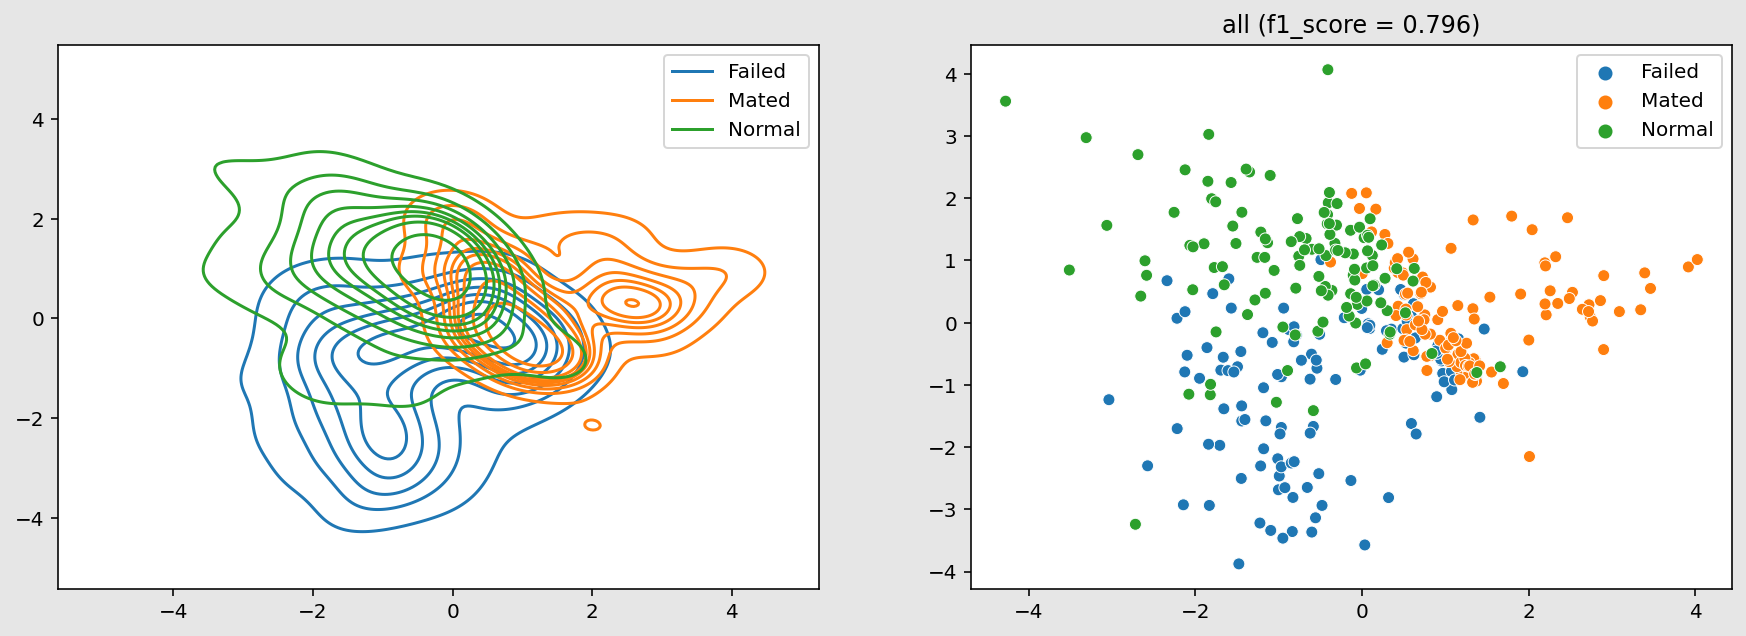

In [9]:
X, Y = chooseDataset(psd_mat, categories, datasets['mating'], balancing=True)
X = normalize(X)

n_epochs = 100
f1_score_train_list = []
f1_score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    lda_model = LDA()
    pcs_train = lda_model.fit_transform(X_train, Y_train)
    # score_train = lda_model.score(X_train, Y_train)
    # score_test = lda_model.score(X_test, Y_test)
    f1_score_train = metrics.f1_score(lda_model.predict(X_train), Y_train, average='macro')
    f1_score_test = metrics.f1_score(lda_model.predict(X_test), Y_test, average='macro')

    f1_score_train_list.append(f1_score_train)
    f1_score_test_list.append(f1_score_test)
    
print('n_epochs: %d'%n_epochs)
print('f1_score_train: %.3f (+- %.3f)' % (np.mean(f1_score_train_list), np.std(f1_score_train_list)))
print('f1_score_test: %.3f (+- %.3f)' % (np.mean(f1_score_test_list), np.std(f1_score_test_list)))
    
# pcs_test = lda_model.transform(X_test)
# plt.figure(figsize=[15,5], dpi=144, facecolor=[0.9,0.9,0.9])
# plt.subplot(1,2,1)
# sns.kdeplot(x=pcs_train[:,0], y=pcs_train[:,1], hue=Y_train)
# # plt.title('train (accuracy = %.3f)'%score_train)
# plt.title('train (f1_score = %.3f)'%f1_score_train)
# plt.subplot(1,2,2)
# sns.scatterplot(x=pcs_test[:,0], y=pcs_test[:,1], hue=Y_test)
# # plt.title('test (accuracy = %.3f)'%score_test)
# plt.title('test (f1_score = %.3f)'%f1_score_test)
# plt.show()

pcs_all= lda_model.fit_transform(X, Y)
plt.figure(figsize=[15,5], dpi=144, facecolor=[0.9,0.9,0.9])
plt.subplot(1,2,1)
sns.kdeplot(x=pcs_all[:,0], y=pcs_all[:,1], hue=Y)
plt.subplot(1,2,2)
sns.scatterplot(x=pcs_all[:,0], y=pcs_all[:,1], hue=Y)
# plt.title('train (accuracy = %.3f)'%score_train)
plt.title('all (f1_score = %.3f)'%f1_score_train)
plt.show()

480 in 716 samples dicarded due to imbalance. 
n_epochs: 100
f1_score_train: 0.891 (+- 0.011)
f1_score_test: 0.847 (+- 0.047)


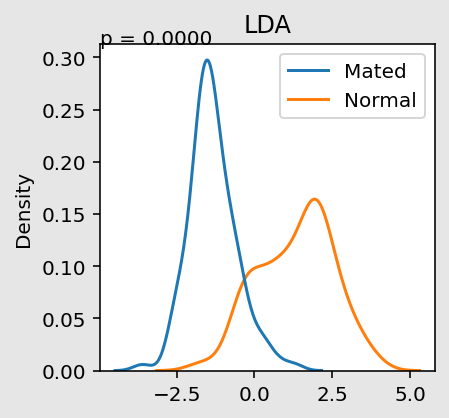

In [10]:
X, Y = chooseDataset(psd_mat, categories, datasets['mating_2'], balancing=True)
X = normalize(X)

lda_model = LDA()
pcs_all = lda_model.fit_transform(X, Y)
plt.figure(figsize=[3,3], dpi=144, facecolor=[0.9,0.9,0.9])
result = doTtest(pcs_all.flatten(), Y)
sns.kdeplot(x=pcs_all.flatten(), hue=Y)
plt.title('LDA')
plt.text(x=plt.xlim()[0], y=plt.ylim()[1], s='p = %.4f'%result.pvalue)

n_epochs = 100
f1_score_train_list = []
f1_score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    lda_model = LDA()
    pcs_train = lda_model.fit_transform(X_train, Y_train)
    # score_train = lda_model.score(X_train, Y_train)
    # score_test = lda_model.score(X_test, Y_test)
    f1_score_train = metrics.f1_score(lda_model.predict(X_train), Y_train, average='macro')
    f1_score_test = metrics.f1_score(lda_model.predict(X_test), Y_test, average='macro')

    f1_score_train_list.append(f1_score_train)
    f1_score_test_list.append(f1_score_test)
    
print('n_epochs: %d'%n_epochs)
print('f1_score_train: %.3f (+- %.3f)' % (np.mean(f1_score_train_list), np.std(f1_score_train_list)))
print('f1_score_test: %.3f (+- %.3f)' % (np.mean(f1_score_test_list), np.std(f1_score_test_list)))
    
# pcs_test = lda_model.transform(X_test)
# plt.figure(figsize=[15,5], dpi=144, facecolor=[0.9,0.9,0.9])
# plt.subplot(1,2,1)
# sns.kdeplot(x=pcs_train.flatten(), hue=Y_train)
# # plt.title('train (accuracy = %.3f)'%score_train)
# plt.title('train (f1_score = %.3f)'%f1_score_train)
# plt.subplot(1,2,2)
# sns.kdeplot(x=pcs_test.flatten(), hue=Y_test)
# # plt.title('test (accuracy = %.3f)'%score_test)
# plt.title('test (f1_score = %.3f)'%f1_score_test)
# plt.show()

159 in 395 samples dicarded due to imbalance. 
n_epochs: 100
f1_score_train: 0.829 (+- 0.014)
f1_score_test: 0.757 (+- 0.061)


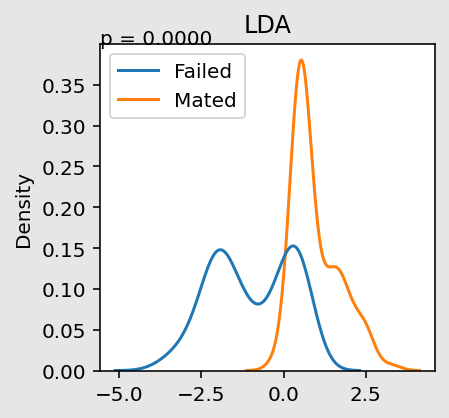

In [16]:
X, Y = chooseDataset(psd_mat, categories, datasets['mating_3'], balancing=True)
X = normalize(X)

lda_model = LDA()
pcs_all = lda_model.fit_transform(X, Y)
plt.figure(figsize=[3,3], dpi=144, facecolor=[0.9,0.9,0.9])
result = doTtest(pcs_all.flatten(), Y)
sns.kdeplot(x=pcs_all.flatten(), hue=Y)
plt.title('LDA')
plt.text(x=plt.xlim()[0], y=plt.ylim()[1], s='p = %.4f'%result.pvalue)

n_epochs = 100
f1_score_train_list = []
f1_score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    lda_model = LDA()
    pcs_train = lda_model.fit_transform(X_train, Y_train)
    # score_train = lda_model.score(X_train, Y_train)
    # score_test = lda_model.score(X_test, Y_test)
    f1_score_train = metrics.f1_score(lda_model.predict(X_train), Y_train, average='macro')
    f1_score_test = metrics.f1_score(lda_model.predict(X_test), Y_test, average='macro')

    f1_score_train_list.append(f1_score_train)
    f1_score_test_list.append(f1_score_test)
    
print('n_epochs: %d'%n_epochs)
print('f1_score_train: %.3f (+- %.3f)' % (np.mean(f1_score_train_list), np.std(f1_score_train_list)))
print('f1_score_test: %.3f (+- %.3f)' % (np.mean(f1_score_test_list), np.std(f1_score_test_list)))
    
# pcs_test = lda_model.transform(X_test)
# plt.figure(figsize=[15,5], dpi=144, facecolor=[0.9,0.9,0.9])
# plt.subplot(1,2,1)
# sns.kdeplot(x=pcs_train.flatten(), hue=Y_train)
# # plt.title('train (accuracy = %.3f)'%score_train)
# plt.title('train (f1_score = %.3f)'%f1_score_train)
# plt.subplot(1,2,2)
# sns.kdeplot(x=pcs_test.flatten(), hue=Y_test)
# # plt.title('test (accuracy = %.3f)'%score_test)
# plt.title('test (f1_score = %.3f)'%f1_score_test)
# plt.show()

# SVM

In [29]:
from sklearn.svm import SVC

In [30]:
X, Y = chooseDataset(psd_mat, categories, datasets['age'])
n_epochs = 100
score_train_list = []
score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    X_train, X_test = normalize_list([X_train, X_test])

    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train, Y_train)
    score_train = svm_model.score(X_train, Y_train)
    score_test = svm_model.score(X_test, Y_test)

    score_train_list.append(score_train)
    score_test_list.append(score_test)
    
print('method: svm, kernel: linear')
print('n_epochs: %d'%n_epochs)
print('score_train: %.3f (+- %.3f)' % (np.mean(score_train_list), np.std(score_train_list)))
print('score_test: %.3f (+- %.3f)' % (np.mean(score_test_list), np.std(score_test_list)))


pred_train = svm_model.predict(X_train)
pred_test = svm_model.predict(X_test)
acc_train = sum(Y_train == pred_train) / len(Y_train)
acc_test = sum(Y_test == pred_test) / len(Y_test)
print(acc_train, acc_test)


method: svm, kernel: linear
n_epochs: 100
score_train: 0.809 (+- 0.006)
score_test: 0.785 (+- 0.022)
0.8050682261208577 0.7713178294573644


In [31]:
X, Y = chooseDataset(psd_mat, categories, datasets['feeding'])
n_epochs = 100
score_train_list = []
score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    X_train, X_test = normalize_list([X_train, X_test])

    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train, Y_train)
    score_train = svm_model.score(X_train, Y_train)
    score_test = svm_model.score(X_test, Y_test)

    score_train_list.append(score_train)
    score_test_list.append(score_test)
    
print('method: svm, kernel: linear')
print('n_epochs: %d'%n_epochs)
print('score_train: %.3f (+- %.3f)' % (np.mean(score_train_list), np.std(score_train_list)))
print('score_test: %.3f (+- %.3f)' % (np.mean(score_test_list), np.std(score_test_list)))


method: svm, kernel: linear
n_epochs: 100
score_train: 0.971 (+- 0.004)
score_test: 0.959 (+- 0.013)


In [32]:
X, Y = chooseDataset(psd_mat, categories, datasets['mating'])
n_epochs = 100
score_train_list = []
score_test_list = []

for idx_epoch in range(n_epochs):
    
    X_train, X_test, Y_train, Y_test = splitDataset(X, Y, test_ratio=0.2)

    X_train, X_test = normalize_list([X_train, X_test])

    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train, Y_train)
    score_train = svm_model.score(X_train, Y_train)
    score_test = svm_model.score(X_test, Y_test)

    score_train_list.append(score_train)
    score_test_list.append(score_test)
    
    
print('method: svm, kernel: linear')
print('n_epochs: %d'%n_epochs)
print('score_train: %.3f (+- %.3f)' % (np.mean(score_train_list), np.std(score_train_list)))
print('score_test: %.3f (+- %.3f)' % (np.mean(score_test_list), np.std(score_test_list)))


method: svm, kernel: linear
n_epochs: 100
score_train: 0.669 (+- 0.010)
score_test: 0.645 (+- 0.021)
